In [4]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
df = pd.read_csv("Klink_Tyler_Dataset_Raw.csv")
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0


In [6]:
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6738 non-null   object 
 1   year          6738 non-null   int64  
 2   price         6738 non-null   int64  
 3   transmission  6738 non-null   object 
 4   mileage       6738 non-null   int64  
 5   fuelType      6738 non-null   object 
 6   tax           6738 non-null   int64  
 7   mpg           6738 non-null   float64
 8   engineSize    6738 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 473.9+ KB


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
count,6738,6738.000000,6738.000000,6738,6738.000000,6738,6738.000000,6738.000000,6738.000000
unique,18,NaN,NaN,4,NaN,4,NaN,NaN,NaN
top,Yaris,NaN,NaN,Manual,NaN,Petrol,NaN,NaN,NaN
freq,2122,NaN,NaN,3826,NaN,4087,NaN,NaN,NaN
mean,NaN,2016.748145,12522.391066,NaN,22857.413921,NaN,94.697240,63.042223,1.471297
std,NaN,2.204062,6345.017587,NaN,19125.464147,NaN,73.880776,15.836710,0.436159
min,NaN,1998.000000,850.000000,NaN,2.000000,NaN,0.000000,2.800000,0.000000
25%,NaN,2016.000000,8290.000000,NaN,9446.000000,NaN,0.000000,55.400000,1.000000
50%,NaN,2017.000000,10795.000000,NaN,18513.000000,NaN,135.000000,62.800000,1.500000
75%,NaN,2018.000000,14995.000000,NaN,31063.750000,NaN,145.000000,69.000000,1.800000


In [10]:
median_price = df['price'].median()
print("Median price:", median_price)
df['HighPrice'] = (df['price'] > median_price).astype(int)
df['HighPrice'].value_counts()

Median price: 10795.0


HighPrice
0    3375
1    3363
Name: count, dtype: int64

In [12]:
max_year = df['year'].max()
df['Age'] = max_year - df['year']
df[['year', 'Age']].head()

,year,Age
0,2016,4
1,2017,3
2,2015,5
3,2017,3
4,2017,3


In [14]:
df.isna().sum()
critical_cols = ['price', 'year', 'mileage', 'fuelType', 'transmission', 'tax', 'mpg', 'engineSize', 'HighPrice', 'Age']
df_clean = df.dropna(subset=critical_cols).copy()
df_clean.shape

(6738, 11)

In [16]:
df_clean.to_csv("Klink_Tyler_Dataset_Clean.csv", index=False)

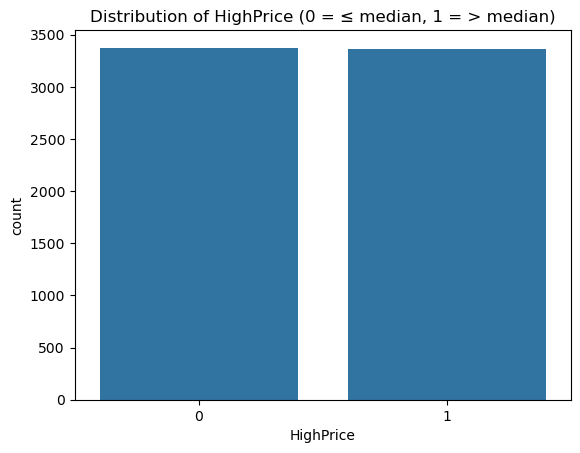

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x='HighPrice', data=df_clean)
plt.title("Distribution of HighPrice (0 = ≤ median, 1 = > median)")
plt.show()

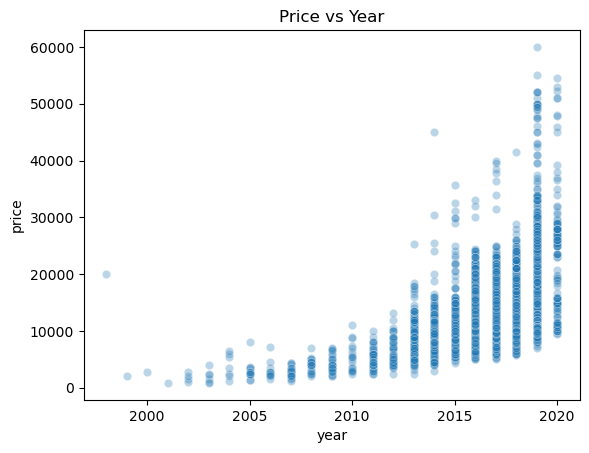

In [20]:
sns.scatterplot(x='year', y='price', data=df_clean, alpha=0.3)
plt.title("Price vs Year")
plt.show()

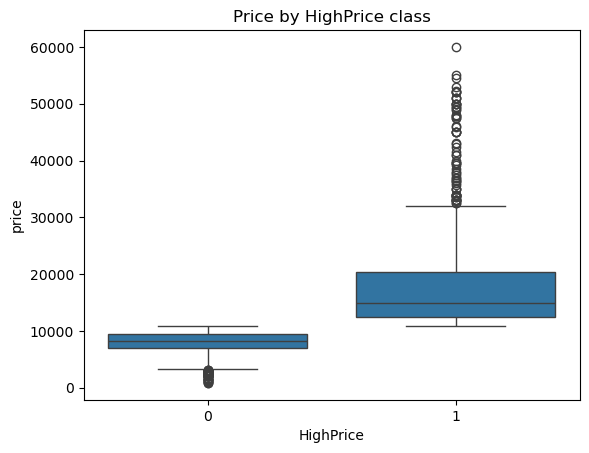

In [22]:
sns.boxplot(x='HighPrice', y='price', data=df_clean)
plt.title("Price by HighPrice class")
plt.show()

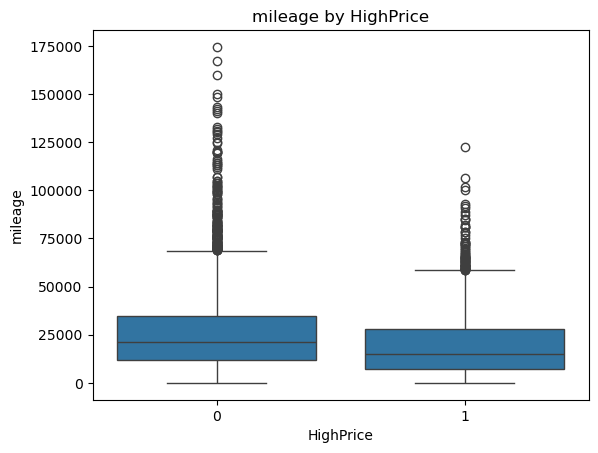

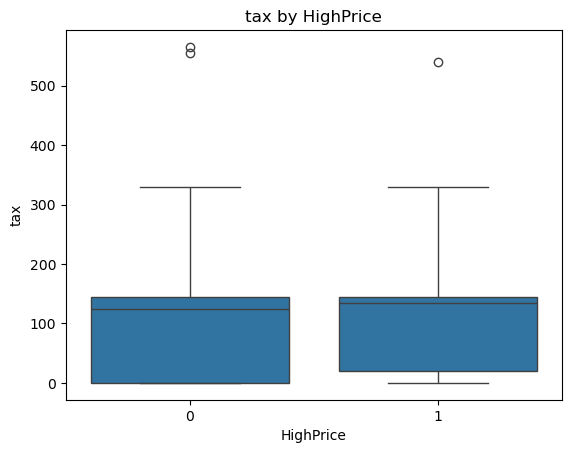

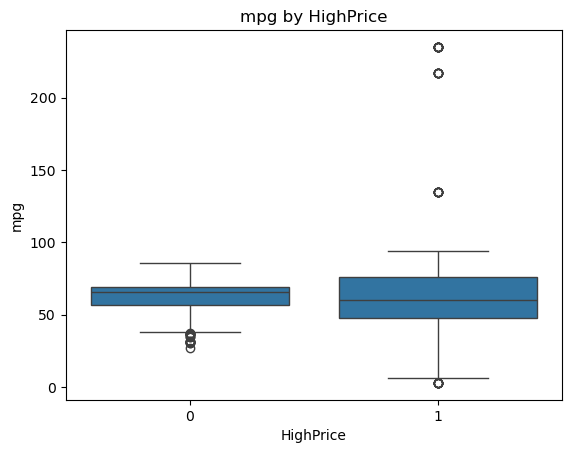

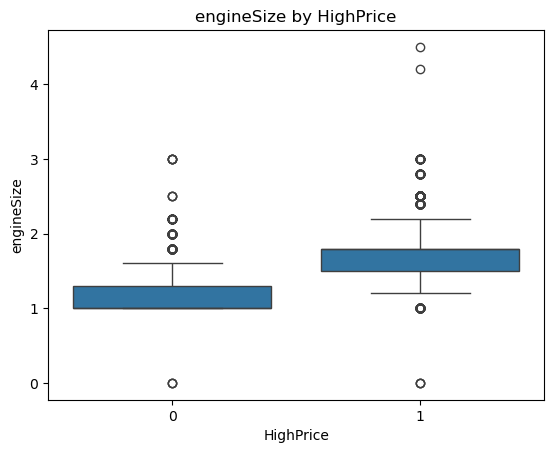

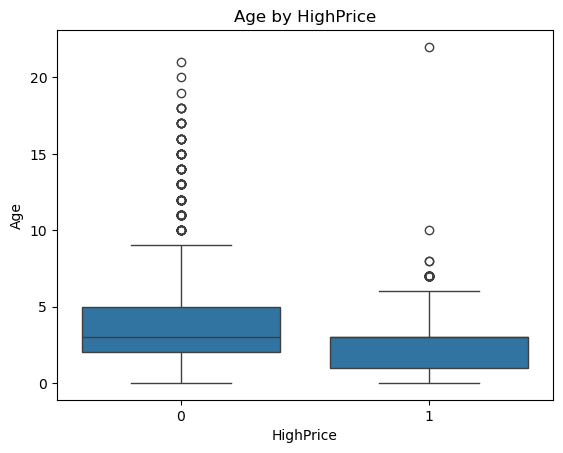

In [24]:
num_cols = ['mileage', 'tax', 'mpg', 'engineSize', 'Age']
for col in num_cols:
    plt.figure()
    sns.boxplot(x='HighPrice', y=col, data=df_clean)
    plt.title(f"{col} by HighPrice")
    plt.show()

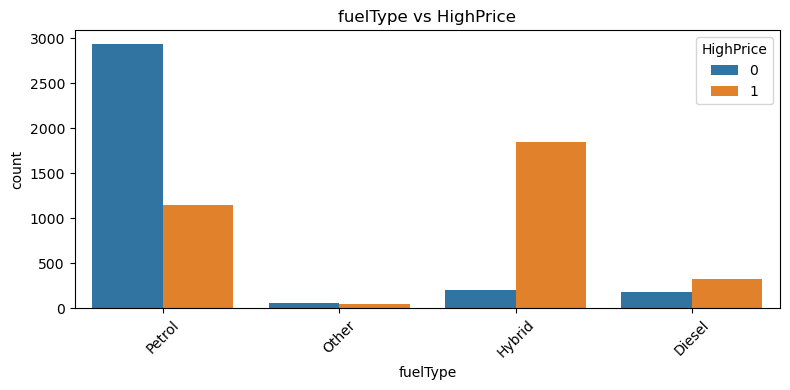

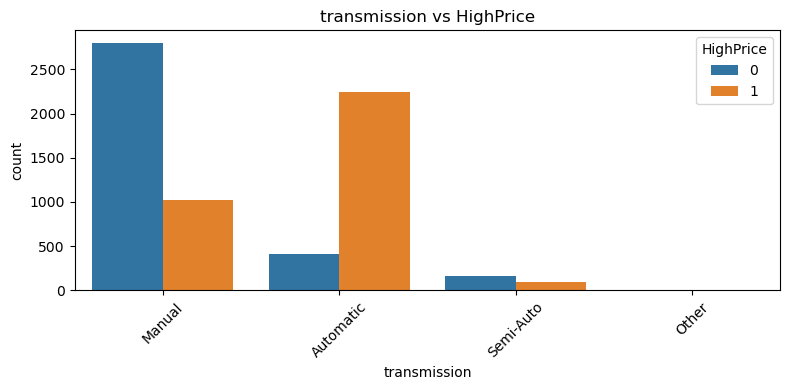

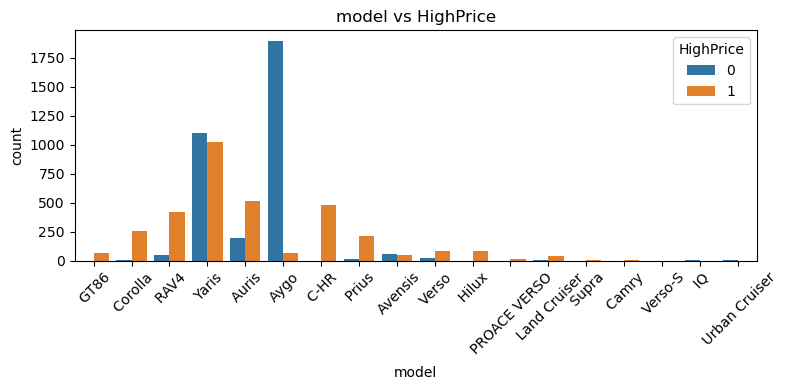

In [26]:
cat_cols = ['fuelType', 'transmission', 'model']
for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, hue='HighPrice', data=df_clean)
    plt.title(f"{col} vs HighPrice")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [30]:
feature_cols_numeric = ['mileage', 'tax', 'mpg', 'engineSize', 'Age']
feature_cols_categorical = ['fuelType', 'transmission', 'model']
X = df_clean[feature_cols_numeric + feature_cols_categorical].copy()
y = df_clean['HighPrice'].copy()

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [34]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, feature_cols_numeric),
        ('cat', categorical_transformer, feature_cols_categorical)
    ]
)

In [36]:
log_reg = LogisticRegression(max_iter=1000)

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', log_reg)
])

In [38]:
from sklearn.metrics import confusion_matrix, classification_report

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Confusion Matrix:
 [[807  37]
 [ 46 795]]

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       844
           1       0.96      0.95      0.95       841

    accuracy                           0.95      1685
   macro avg       0.95      0.95      0.95      1685
weighted avg       0.95      0.95      0.95      1685



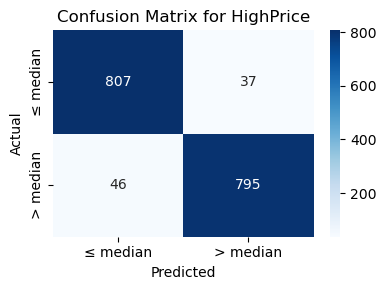

In [40]:
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['≤ median', '> median'],
            yticklabels=['≤ median', '> median'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for HighPrice')
plt.tight_layout()
plt.show()

In [42]:
log_reg_model = clf.named_steps['classifier']
ohe = clf.named_steps['preprocessor'].named_transformers_['cat']

ohe_feature_names = ohe.get_feature_names_out(feature_cols_categorical)

all_feature_names = np.concatenate([feature_cols_numeric, ohe_feature_names])

coefs = log_reg_model.coef_[0]

coef_df = pd.DataFrame({
    'feature': all_feature_names,
    'coef': coefs
}).sort_values(by='coef', ascending=False)

coef_df.head(15)

,feature,coef
23,model_ Prius,3.001374
15,model_ C-HR,2.649496
24,model_ RAV4,2.596089
6,fuelType_Hybrid,2.525068
18,model_ GT86,1.868307
3,engineSize,1.830013
9,transmission_Automatic,1.411427
11,transmission_Semi-Auto,0.340630
27,model_ Verso,0.332068
19,model_ Hilux,0.298677


In [ ]:
#Positive coefficient → increases log-odds of “HighPrice = 1” (more likely above median).
#Negative coefficient → decreases log-odds of “HighPrice = 1” (more likely at or below median).